# 02. From Neuron to Neural Network

<div style="margin:.3rem 0 1rem;font-size:.9em;color:#555;display:flex;align-items:center;gap:.35rem;font-family:monospace">
  <time datetime="2025-02-08">8 Feb 2025</time> /
  <time datetime="2026-02-06">6 Feb 2026</time>
</div>

<a href="https://colab.research.google.com/github/shahaliyev/csci4701/blob/main/docs/notebooks/02_neural_network.ipynb"
   target="_blank" rel="noopener">
  <img
    src="https://colab.research.google.com/assets/colab-badge.svg"
    alt="Open in Colab"
  />
</a>

<div class="admonition info">
  <p class="admonition-title">Info</p>
  <p style="margin: 1em 0;">The following source was consulted in preparing this material: <a href='https://www.youtube.com/watch?v=VMj-3S1tku0&t=6309s'>Andrej Karpathy's lecture</a> on <a href='https://github.com/karpathy/micrograd'>Micrograd</a>.</p>
</div>

In the previous notebook on [backpropagation](../01_backprop) we saw the internals of the autograd engine and a basic implementation of gradient descent. Our simplistic backpropagation algorithm was optimizing the output of a simple function. Towards the end, we also saw the PyTorch implementation of the learned concepts.

In [1]:
# This is a graph visualization code from micrograd, no need to understand the details
# https://github.com/karpathy/micrograd/blob/master/trace_graph.ipynb
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.3f | grad %.3f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

## Activation Function

The function $f(x) = x * w$ is a linear function always passing from origin. The real world data, however, will be much more complex, and in order to describe a pattern in the data our Machine Learning model should return a more flexible function. For that, we will do two things: add bias $b$ (recall _affine transformations_ from [linear algebra](../../mathematics/02_linear_algebra)) and bring **non-linearity** with an _activation function_. We can choose different non-linear <a href='https://en.wikipedia.org/wiki/Activation_function'>activation functions</a> with the condition that it should be differentiable (otherwise we won't be able to calculate gradients for backpropagation). We will implement [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) (logistic) activation function which has the following formula:

$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

Sigmoid function not only makes a linear function non-linear and continuous, but also maps any value of $x$ to be between $0$ and $1$. It may be useful when we want to, say, predict probabilities for different output classes.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def sigmoid(x):
  return 1.0 / (1 + np.exp(-x))

In [4]:
# below is a simple linear function where any activation will be applied
# recall that sigmoid is one of many possible choices
def f(x, w=0.5, b=10, activation=None):
  out = x * w + b
  return activation(out) if activation else out

In [5]:
def plot(f, x, activation=None):
  plt.figure(figsize=(4, 4))
  x_all = np.linspace(-50, 50, 100)
  y_all = f(x_all, activation=activation)
  plt.plot(x_all, y_all)
  plt.scatter(x, f(x, activation=activation), color='r')
  plt.show()

What we wrote above is a bunch of helper functions to keep us flexible when testing different functions. We can start with a simple linear function with default weight and bias.

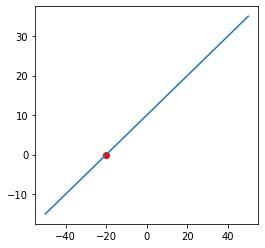

In [6]:
x = -20
plot(f, x) # f(x)=0.5x+10

Now we will plot the exact same point mapped into the non-linear sigmoid function, which has the range between $0$ and $1$. 

<div class="admonition tip">
  <p class="admonition-title">Tip</p>
  <p style="margin: 1em 0;">
    Try out different $x$ values and see the plots and gain intuition on how the mapping gets shifted.
  </p>
</div>

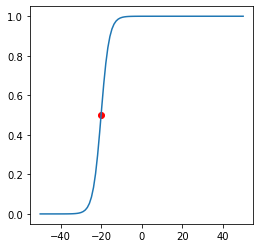

In [7]:
plot(f, x, sigmoid)


<div class="admonition success">
  <p class="admonition-title">Exercise</p>
  <p style="margin: 1em 0;">
    Implement other activation functions (e.g. <a href='https://en.wikipedia.org/wiki/Rectified_linear_unit'>ReLU</a>) and see their plot. What could be the distadvantage of using sigmoid activation function?
  </p>
</div>

We will now make some updates to the `Value` class which we have been developing over the course of the [previous notebook](../01_backprop). Not only the sigmoid function should be added to the class &ndash; we should be able to calculate the derivative of it as well.

<div class="admonition success">
  <p class="admonition-title">Exercise</p>
  <p style="margin: 1em 0;">
    Find the derivative of the sigmoid function. </p>
</div>

## Backpropagation Engine

At this point, we need to take a breath and improve our `Value` class. This step will make our future demonstrations smooth for discussing artificial neurons and neural network. 

As have been noted, adding activation (sigmoid) logic should  be the first step. However, we will make further adjustments to align our code with the PyTorch implementation we had discussed earlier and simplify our future workflow. Understanding the details in the code is preferable but not necessary. Gaining intuition for the purpose of each function is enough to proceed to the next sections.

We add the `requires_grad` flag to tell us which parameters are trainable and requires gradient calculation and update. For example, it doesn't make sense to modify the training inputs for our model which is provided to us through collected data. Indeed, we shouldn't spend resources for calculating unnecessary gradients. Our goal is to nudge only the parameters, as well as the nodes dependent on them, in order to minimize the eventual loss.

Our computation graph will soon be much bigger than what it was before. The `_backward` pass function we call manually on each node is not scalable. Ideally, we should have a single function `backward()` to calculate all the gradients, which we previously saw in the PyTorch implementation. For that, we will need to sort the nodes of the computation graph (from input nodes until the output node). We can achieve that with the [topological sort](https://en.wikipedia.org/wiki/Topological_sorting) algorithm implemented for [micrograd](https://github.com/karpathy/micrograd/blob/master/micrograd/engine.py).

Lastly, we will add the function `optimize()` which will calculate gradient descent while using this sorted topology. Instead of overriding gradients (`=`), we will accumulate them (`+=`) to avoid gradient update bugs when using the same node more than once in an operation. And as a consequence, we will have to reset gradients with `zero_()` (again, similar to PyTorch) so that the gradients of different backward passes will not affect each other (it serves the exact same purpose as `self.grad = 0.0` was serving before the gradient accumulation). 

<div class="admonition warning">
  <p class="admonition-title">Important</p>
  <p style="margin: 1em 0;">
    Although we try to imitate PyTorch’s API as closely as possible, there is a certain difference in how gradient resetting is handled.
    In our implementation, <code>Value.zero_()</code> resets only the gradient stored in this single <code>Value</code> node (<code>self.grad</code>), while <code>Value.zero_grad()</code> clears gradients for all trainable nodes collected in <code>self.params</code>.
    In PyTorch, <code>tensor.zero_()</code> is a general in-place operation that zeros the tensor’s data (not its gradients), whereas gradient clearing is typically performed via <code>optimizer.zero_grad()</code>, which resets gradients for all parameters tracked by the optimizer (an individual gradient tensor may also be reset via <code>param.grad.zero_()</code> if it exists).
  </p>
</div>

In [8]:
class Value:
  def __init__(self, data, _prev=(), _op='', requires_grad=False, label=''):
    self.data = data
    self._prev = _prev
    self._op = _op
    self.label = label
    self._backward = lambda: None
    self.grad = 0.0
    self.requires_grad = requires_grad

  def __add__(self, other):
    data = self.data + other.data
    out = Value(data, (self, other), '+', self.requires_grad or other.requires_grad)

    def _backward():
      if self.requires_grad:
        self.grad += 1.0 * out.grad
      if other.requires_grad:
        other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    data = self.data * other.data
    out = Value(data, (self, other), '*', self.requires_grad or other.requires_grad)

    def _backward():
      if self.requires_grad:
        self.grad += other.data * out.grad
      if other.requires_grad:
        other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __sub__(self, other):
    return self + (Value(-1) * other)

  def sigmoid(self):
    s = 1.0 / (1 + np.exp(-self.data))
    out = Value(s, (self, ), 'sigmoid', self.requires_grad)

    def _backward():
      if self.requires_grad:
        self.grad += s * (1.0 - s) * out.grad
    out._backward = _backward

    return out

  def build_topo(self):
    # Builds a topological ordering of the computation graph
    topo = []
    visited = set()

    def _build_topo(node):
      if node not in visited:
        visited.add(node)
        for child in node._prev:
          _build_topo(child)
        topo.append(node)
    _build_topo(self)

    return topo

  def parameters(self):
    # Returns all trainable nodes reachable from this node
    topo = self.build_topo()
    return [node for node in topo if node.requires_grad and len(node._prev) == 0]


  def backward(self):
    # Computes gradients for all nodes in the graph
    if self.requires_grad:
      topo = self.build_topo()
      self.grad = 1.0
      for node in reversed(topo):
        node._backward()

  def optimize(self, lr=0.01):
    # Applies gradient descent to all trainable parameters
    for node in self.parameters():
      node.data -= lr * node.grad

  def zero_(self):
    self.grad = 0.0

  def zero_grad(self):
    # Resets gradients of all trainable parameters in the graph
    for node in self.parameters():
      node.grad = 0.0

  def __repr__(self):
    return f'Value(data={self.data}, grad={self.grad}, label={self.label})'

Once the engine is set, we are now ready to start our discussions and build our neural network step by step. 

## Artificial Neuron

<figure>
  <img src="../../assets/images/overview/artificial_neuron.svg" alt="artificial neuron" style="max-width: 80%; height: auto;">
  <figcaption style="margin-top: 0.5em; font-size: 0.9em; opacity: 0.85;"> Artificial Neuron ~ By <a href="//commons.wikimedia.org/wiki/User:Funcs" title="User:Funcs">Funcs</a> - <span class="int-own-work" lang="en">Own work</span>, <a href="http://creativecommons.org/publicdomain/zero/1.0/deed.en" title="Creative Commons Zero, Public Domain Dedication">CC0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=148910507">Link</a>
  </figcaption>
</figure>

An artificial neuron is simply a linear function passing through an activation function  (e.g. $\sigma(x * w + b)$). The illustration above describes an $N$-dimensional neuron, accepting inputs $x_1, x_2, \dots, x_n$. The function $f$ we had above is a very simple neuron with $1$-dimensional input.

<div class="admonition success">
  <p class="admonition-title">Exercise</p>
  <p style="margin: 1em 0;">
    What could be input values of a neuron for predicting the probability of a customer cancelling their subscription?
  </p>
</div>

We will initially implement a simple `Neuron` class in 3D ($2$-dimensional input values and an output value). The function will receive two inputs `x1` and `x2`, which will become `Value` objects. Their weights `w1` and `w2` will be initialized randomly from the [uniform distribution](https://www.acsu.buffalo.edu/~adamcunn/probability/uniform.html) $w_1, w_2 \sim \mathcal{U}(-1, 1)
$ and will determine how much each of the inputs influences the outcome.

In [9]:
class Neuron:
  def __init__(self):
    self.w1 = Value(np.random.uniform(-1, 1), label='w1', requires_grad=True)
    self.w2 = Value(np.random.uniform(-1, 1), label='w2', requires_grad=True)
    self.b = Value(0, label='b', requires_grad=True)

  def __call__(self, x1, x2):
    out = x1 * self.w1 + x2 * self.w2 + self.b
    return out.sigmoid()

Now we can initialize our inputs and neuron to see our computation graph. Our loss will be simple: the squared error between the ground truth label $y$ and the predicted probability. It has a minimum exactly when prediction is equal to the ground truth. Thanks to our backpropagation engine, we now have the `backward()` function which can calculate the partial derivates for all the nodes. Once we plot the graph, pay attention that the input and leaf node gradients which we have no control over are not calculated, thanks to `requires_grad`.

!!! note
    Our input values $x_1$ and $x_2$ may correspond to a customer who made the purchase ($y = 1$).

In [10]:
x1 = Value(2, label='x1')
x2 = Value(3, label='x2')
y  = Value(1, label= 'y')

n = Neuron()

pred = n(x1, x2);              pred.label = 'pred'
L = (y - pred) * (y - pred);   L.label = 'loss'

L.backward()

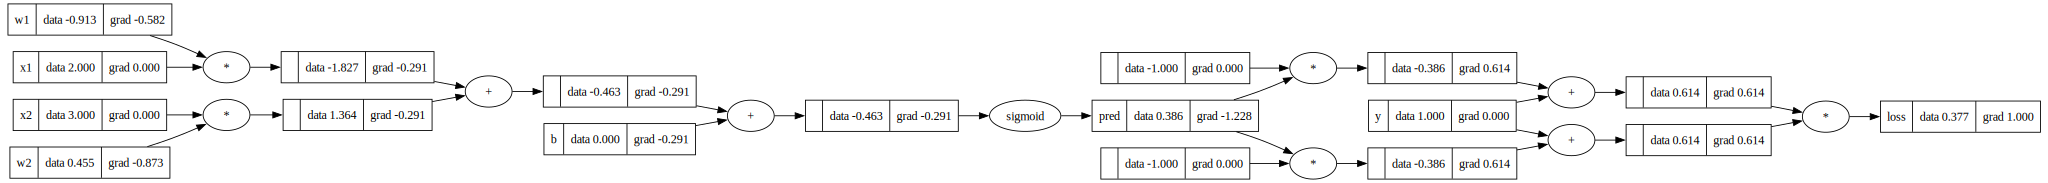

In [11]:
draw_dot(L)

In [12]:
# The helper function here is for plotting, no need to understand it
from mpl_toolkits.mplot3d import Axes3D

def plot_neuron_3d(neuron, x_range=(-5, 5), num=100, activation='sigmoid'):
  x1_vals = np.linspace(x_range[0], x_range[1], num)
  x2_vals = np.linspace(x_range[0], x_range[1], num)
  X1, X2 = np.meshgrid(x1_vals, x2_vals)
  Z = np.zeros_like(X1)

  for i in range(X1.shape[0]):
    for j in range(X1.shape[1]):
      x1 = Value(X1[i, j])
      x2 = Value(X2[i, j])
      Z[i, j] = neuron(x1, x2).data

  fig = plt.figure(figsize=(10, 8))
  ax = fig.add_subplot(111, projection='3d')
  ax.plot_surface(X1, X2, Z, cmap='viridis')
  ax.set_title(f'Neuron output with {activation} activation')
  plt.show()

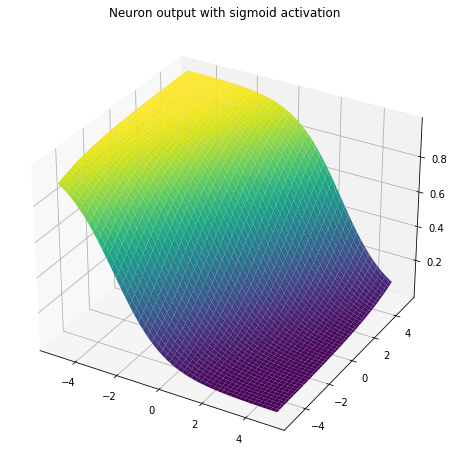

In [13]:
plot_neuron_3d(n)

The ground truth label tells us that we should push our neuron output towards `1.0`. In other words, as our loss $L$ here is a simple squared error value corresponding to $(y - y_hat)^2$, we should try to minimize the loss down to zero with backpropagation. Let's repeat the backpropagation in multiple epochs to reduce loss. We will also print the parameters to see when our neuron function returns a higher probability for the given input values. And we will make sure to not forget to reset the gradients. What you see below is a typical training workflow you will encounter in many implementations, most closely associated with PyTorch.

In [14]:
x1 = Value(2, label='x1')
x2 = Value(3, label='x2')
y  = Value(1, label= 'y')

n = Neuron()

In [15]:
# hyperparameters
lr = 0.01
epochs = 1000

for e in range(epochs):
  # forward pass
  pred = n(x1, x2)
  L = (y - pred) * (y - pred)

  # gradient reset
  L.zero_grad()
  # backward pass
  L.backward()
  # gradient descent
  L.optimize(lr)

  if (e + 1) % 100 == 0:
    print(f'Epoch [{e + 1}/{epochs}], Loss: {L.data:.4f}')

print(f'\nInputs: {x1, x2}')
print(f'Parameters: {n.w1} {n.w2} {n.b}')
print(f'Prediction probability: {pred.data}')


Epoch [100/1000], Loss: 0.9761
Epoch [200/1000], Loss: 0.9648
Epoch [300/1000], Loss: 0.9352
Epoch [400/1000], Loss: 0.7494
Epoch [500/1000], Loss: 0.0621
Epoch [600/1000], Loss: 0.0185
Epoch [700/1000], Loss: 0.0102
Epoch [800/1000], Loss: 0.0069
Epoch [900/1000], Loss: 0.0052
Epoch [1000/1000], Loss: 0.0042

Inputs: (Value(data=2, grad=0.0, label=x1), Value(data=3, grad=0.0, label=x2))
Parameters: Value(data=0.07754978581518703, grad=-0.015539894979151484, label=w1) Value(data=0.6650625956942215, grad=-0.023309842468727228, label=w2) Value(data=0.526204300126792, grad=-0.007769947489575742, label=b)
Prediction probability: 0.9355595866688061


## N-dimensional Neuron

We have just now trained our $2$-dimensional input neuron to find suitable parameter values for achieving a high probability for the given input values. Now we would like to create an $N$-dimensional neuron which will accept much more inputs, similar to what we saw in the illustration of artificial neuron. As a consequence, our neuron will have to learn the parameter values for $N$-dimensional weights:  $w_1, w_2, \dots, w_n$.

In [16]:
class Neuron:
  def __init__(self, N):
    self.W = [Value(np.random.uniform(-1, 1), label=f'w{i}', requires_grad=True) for i in range(N)]
    self.b = Value(0, label='b', requires_grad=True)

  def __call__(self, X):
    out = sum((x * w for x, w in zip(X, self.W)), self.b)
    return out.sigmoid()

We will now see the training output of our $N$-dimensional neuron which will accept $N$ `Value` inputs as a list. Recall from your introductory [machine learning](../../introduction/02_machine_learning) course that linear model followed by a sigmoid (logistic) activation forms the model used in [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression).

In [17]:
X = [Value(x, label=f'x{i}') for i, x in enumerate([5, 0.4, -1, -2])]

n = Neuron(len(X))

pred = n(X);                   pred.label = 'pred'
L = (y - pred) * (y - pred);   L.label = 'loss'

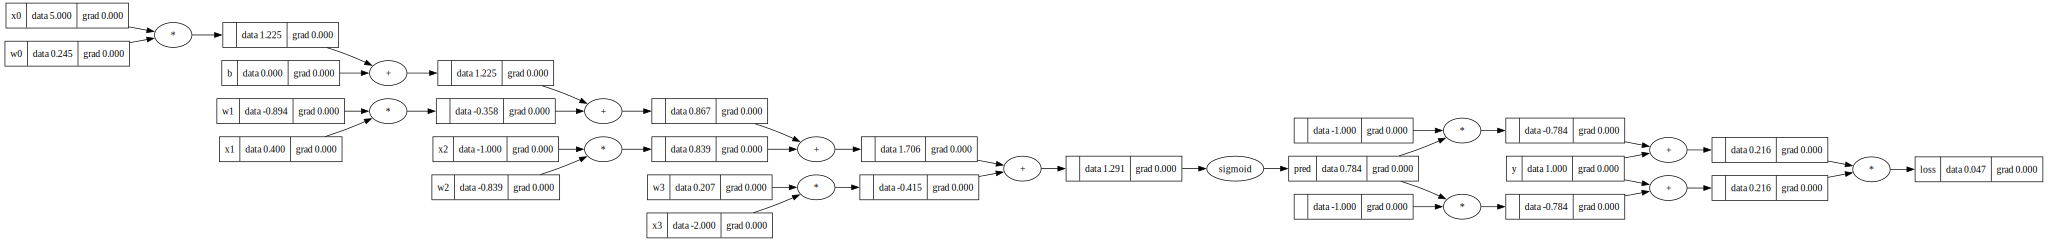

In [18]:
draw_dot(L)

In [19]:
# hyperparameters
lr = 0.01
epochs = 1000

for e in range(epochs):
  pred = n(X)
  L = (y - pred) * (y - pred)

  L.zero_grad()
  L.backward()
  L.optimize(lr)

  if (e + 1) % 100 == 0:
    print(f'Epoch [{e + 1}/{epochs}], Loss: {L.data:.4f}')

print(f'\nInputs: {X}')
print(f'Parameters: {n.W} {n.b}')
print(f'Prediction probability: {pred.data}')

Epoch [100/1000], Loss: 0.0087
Epoch [200/1000], Loss: 0.0045
Epoch [300/1000], Loss: 0.0030
Epoch [400/1000], Loss: 0.0023
Epoch [500/1000], Loss: 0.0018
Epoch [600/1000], Loss: 0.0015
Epoch [700/1000], Loss: 0.0013
Epoch [800/1000], Loss: 0.0011
Epoch [900/1000], Loss: 0.0010
Epoch [1000/1000], Loss: 0.0009

Inputs: [Value(data=5, grad=0.0, label=x0), Value(data=0.4, grad=0.0, label=x1), Value(data=-1, grad=0.0, label=x2), Value(data=-2, grad=0.0, label=x3)]
Parameters: [Value(data=0.5976493875597305, grad=-0.008520328402593043, label=w0), Value(data=-0.8659527976184913, grad=-0.0006816262722074435, label=w1), Value(data=-0.9094188137928199, grad=0.0017040656805186085, label=w2), Value(data=0.06623841805723128, grad=0.003408131361037217, label=w3)] Value(data=0.07054619736664514, grad=-0.0017040656805186085, label=b)
Prediction probability: 0.9703680714362221


## Artificial Neural Network

<figure>
  <img src="../../assets/images/neural_network/ann.svg" alt="artificial neuron" style="max-width: 80%; height: auto;">
  <figcaption style="margin-top: 0.5em; font-size: 0.9em; opacity: 0.85;"> Artificial Neuron Network ~ By <a href="https://en.wikipedia.org/wiki/User:Cburnett" class="extiw" title="en:User:Cburnett">en:User:Cburnett</a> - <span class="int-own-work" lang="en">Own work</span><span typeof="mw:File"><a href="//commons.wikimedia.org/wiki/File:Inkscape-ws.svg" class="mw-file-description"></a></span>&nbsp;This W3C-unspecified <a href="https://en.wikipedia.org/wiki/Vector_images" class="extiw" title="w:Vector images">vector image</a> was created with <a href="https://en.wikipedia.org/wiki/Inkscape" class="extiw" title="w:Inkscape">Inkscape</a> ., <a href="http://creativecommons.org/licenses/by-sa/3.0/" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=1496812">Link</a>
  </figcaption>
</figure>

We managed to train our single neuron to learn a function for our input values. In reality, however, data is much more complex and we need to learn more complication functions. How to achieve that? By chaining many neurons together.

You can think that each neuron will basically learn some portion of the overall function. What we see above is an illustration of an artificial neural network. In the _input layer_ we have three neurons, each separately accepting $N$-dimensional input values. The output values of each neuron are then _fully connected_, as inputs to the _hidden layer_ with four neurons (note that there can be more than one hidden layer). And finally, the output of hidden layer neurons are passed as inputs to the _output layer_, which may, for example, predict probability scores for two classes.

We will now try to implement a fully connected feedforward neural network, which is often referred to as [multilayer perceptron (MLP)](https://en.wikipedia.org/wiki/Multilayer_perceptron).

In [20]:
class Layer:
  def __init__(self, N, count):
    self.neurons = [Neuron(N) for _ in range(count)]

  def __call__(self, X):
    outs = [n(X) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs # flattening dimension if a single element

The code above creates a list of `count` number of neurons, each accepting `N` dimensional input. Let's build our layers shown in the illustration above and connect them. Note that the input dimension of the next layer is the amount of neurons in the previous layer.

In [21]:
# input data and its dimension
X = [Value(x, label=f'x{i}') for i, x in enumerate([1, 4, -3, -2, 3])]
N = len(X)

In [22]:
# creating layers
in_layer = Layer(N, 3)
hid_layer = Layer(3, 4)
out_layer = Layer(4, 2)

In [23]:
# output of each layer is input to the next
X_hidden = in_layer(X)
X_output = hid_layer(X_hidden)
out = out_layer(X_output)

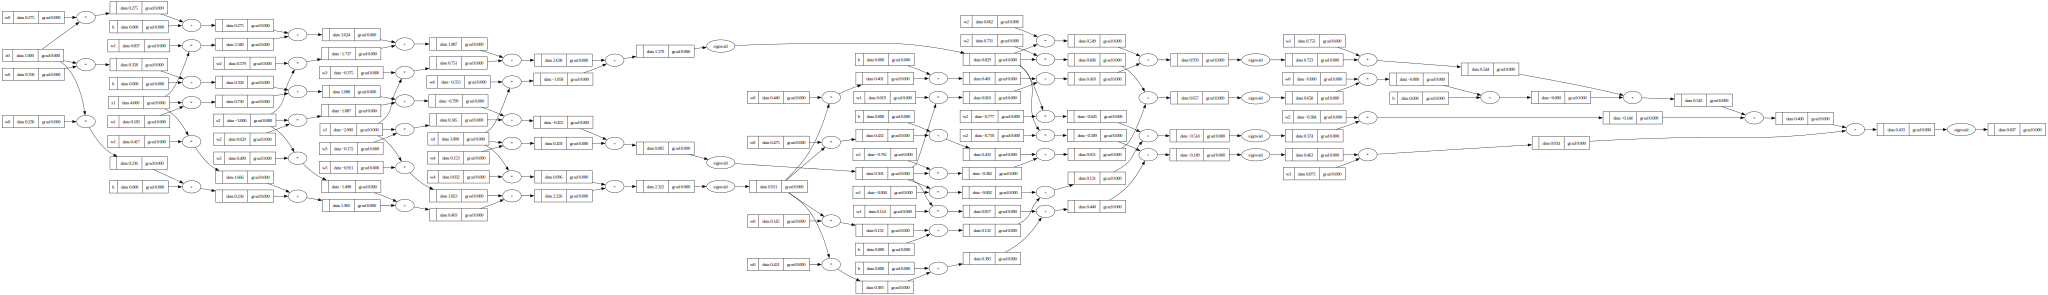

In [24]:
# let's plot either one of the outputs
draw_dot(out[0])

We will further abstract away the neuron and layer creation inside the `MLP` class. Here, `counts` will provide the length of each layer as a list. We will then reimplement the exact same network.

In [25]:
class MLP:
  def __init__(self, N, counts):
    dims = [N] + counts # concatenates dimensions
    self.layers = [Layer(dims[i], dims[i+1]) for i in range(len(dims)-1)]

  def __call__(self, X):
    out = X
    for layer in self.layers:
      out = layer(out)
    return out

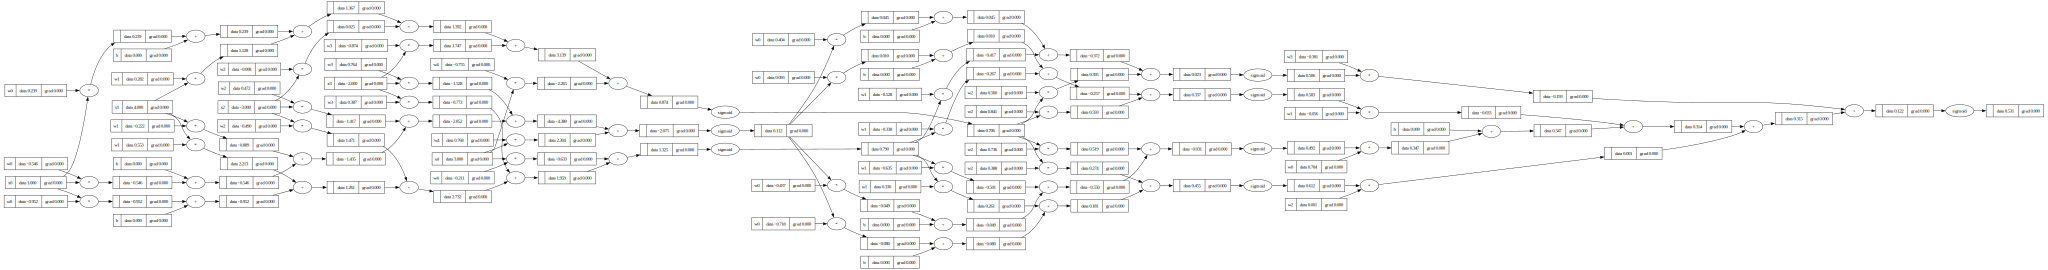

In [26]:
nn = MLP(N, [3, 4, 2])
out = nn(X)
draw_dot(out[0]) # out[1] will return the second output

## Training on a Dataset

It is time to evaluate our network. Even though applying multilayer perceptron to the [`make_moons` dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) is overkill (as the dataset is simple), it will be a nice demonstration of our  classifier's capacity. This time, we will be imitating the well-known [scikit-learn](https://scikit-learn.org/) library.

The `make_moons` dataset consists of $2$-dimensional input samples with two possible output classes. Each sample represents a point in the plane, and the task is to classify it into one of the two interleaving half-moon shapes. Because the classes are not linearly separable, simple linear models such as logistic regression are limited when solving this task.

In [27]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=500, noise=0.1, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print(f'Train data shape: {X_train.shape}, {y_train.shape}')
print(f'Test data shape: {X_test.shape}, {y_test.shape}')
print(f'Input Samples:\n {X_train[:5]}')
print(f'Labels:\n {y_train[:5]}')


Train data shape: (400, 2), (400,)
Test data shape: (100, 2), (100,)
Input Samples:
 [[ 0.74890763 -0.43771955]
 [ 1.52835581 -0.39408701]
 [ 0.25912638  0.45185818]
 [-0.94183179  0.48862655]
 [ 1.91516125  0.13943777]]
Labels:
 [1 1 1 0 1]


Let's try out two provided classifiers, `LogisticRegression` and `MLPClassifier`, the latter of which can be seen as a generalization of the former, which we will soon implement in its simplistic form. As we have already discussed, `LogisticRegression` is basically our `Neuron` class which uses sigmoid (logistic) function as its activation. And in fact, logistic regression will simply be our MLP with the layer size for just a single neuron. Thanks to `numpy` [vectorization](https://stackoverflow.com/questions/75667527/numpy-vectorization-and-algorithmic-complexity) and other optimizations, the `sklearn` implementations will be extremely quick.

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [29]:
model = LogisticRegression()
model.fit(X_train, y_train)
preds = model.predict(X_test)
accuracy = accuracy_score(y_test, preds)
f"Logistic Regression Accuracy: {accuracy:.2f}"

'Logistic Regression Accuracy: 0.84'

In [30]:
model = MLPClassifier(max_iter=1000)
model.fit(X_train, y_train)
preds = model.predict(X_test)
accuracy = accuracy_score(y_test, preds)
f"MLP Classifier Accuracy: {accuracy:.2f}"

'MLP Classifier Accuracy: 1.00'

## Custom MLP Classifier

We will now prepare our dataset by converting data items to `Value` objects.

In [31]:
X_train = [[Value(x) for x in sample] for sample in X_train]
X_test  = [[Value(x) for x in sample] for sample in X_test]
y_train = [Value(y) for y in y_train]
y_test  = [Value(y) for y in y_test]

We will attept to train our classifier in the style of `scikit-learn` models, more specifically [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier). Since our minimal `Value` class does not include logarithms yet, we will train using [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error) as a simple alternative.

<div class="admonition success">
  <p class="admonition-title">Exercise</p>
  <p style="margin: 1em 0;">
    In standard binary classification, the usual choice is binary <a href='https://en.wikipedia.org/wiki/Cross-entropy'>cross-entropy</a> (log loss). Try to modify our backpropagation engine to include the operation of logarithm and update our loss function below to achieve a higher accuracy. We will introduce the concept of entropy when discussing <a href='../../mathematics/04_information'>information theory</a>.
  </p>
</div>

In [32]:
class Classifier:
  def __init__(self, layer_sizes=[3, 1]):
    self.layer_sizes = layer_sizes
    self.nn = None
    self.L = None
    self.iterations = 0

  def forward(self, Xs):
    return [self.nn(X) for X in Xs]

  def predict(self, X_test):
    return self.forward(X_test)

  def train(self, X_train, y_train, lr, epoch, num_epochs, verbose):
    preds = self.forward(X_train)
    self.L = self.mean_squared_error(y_train, preds)
    self.L.zero_grad()
    self.L.backward()
    self.L.optimize(lr=lr)

    if verbose:
      print(f'[{epoch}/{num_epochs}] loss: {self.L.data:.4f}')

  def fit(self, X_train, y_train, lr=0.01, num_epochs=1000):
    if self.nn is None:
      self.nn = MLP(len(X_train[0]), self.layer_sizes)
    for i in range(num_epochs):
      do_print = (i % 100 == 99) or (i == 0)
      self.train(X_train, y_train, lr, i + 1, num_epochs, do_print)
    self.iterations += num_epochs

  def mean_squared_error(self, y_train, preds):
    inv_n = Value(1.0 / len(y_train))
    return sum([(y - p) * (y - p) for y, p in zip(y_train, preds)],Value(0)) * inv_n

  def score(self, y_test, preds, threshold=0.5):
    correct = 0
    for y, p in zip(y_test, preds):
      pred_label = 1 if p.data >= threshold else 0
      true_label = 1 if y.data >= 0.5 else 0
      correct += (pred_label == true_label)
    return correct / len(y_test)

Our classifier is ready and we can now train our model and note the accuracy. However, unlike the optimized classifiers of the `sklearn` library, it will be much slower and inefficient. Try out experiments with different hyperparameters (e.g. layer sizes, learning rates), and notice how it affects the training process and loss. As mentioned earlier, logistic regression is recovered by using a network with no hidden layer and a single sigmoid output with `layer_sizes=[1]`.

In [33]:
# model = Classifier([1])
model = Classifier([4, 1])

In [34]:
model.fit(X_train, y_train, lr=0.1, num_epochs=1000)

[1/1000] loss: 0.2977
[100/1000] loss: 0.2506
[200/1000] loss: 0.2343
[300/1000] loss: 0.2134
[400/1000] loss: 0.1866
[500/1000] loss: 0.1591
[600/1000] loss: 0.1374
[700/1000] loss: 0.1228
[800/1000] loss: 0.1132
[900/1000] loss: 0.1066
[1000/1000] loss: 0.1019


In [35]:
preds = model.predict(X_train)
print(f'Custom MLP classifier accuracy on train data: {model.score(y_train, preds):.2f}')

Custom MLP classifier accuracy on train data: 0.85


In [36]:
preds = model.predict(X_test)
print(f'Custom MLP classifier accuracy on test data: {model.score(y_test, preds):.2f}')

Custom MLP classifier accuracy on test data: 0.82



We had just built and trained a neural network step by step, starting with activation functions and updated backpropagation engine. We defined an artificial neuron as a weighted sum followed by a nonlinear activation, extended it to an $N$-dimensional neuron, and combined multiple neurons into layers to form a multilayer perceptron. We then trained this network on a real dataset and wrapped it in a custom MLP classifier with a familiar `sklearn` interface. In the next notebook, we will introduce [convolutional neural networks (CNN)](../03_cnn_torch) and apply them to the well-known handwritten digit dataset.